In [1]:
import sys
import pytraj as pt
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial

from BKit.TransitionKernel import TransitionKernel
from BKit.KinSolvers import KineticsQK

In [2]:
DIR_SAVE = '../output/'

print("reading inputs from " + DIR_SAVE)
MIDX = np.load(DIR_SAVE + 'CellIndx.npy')

reading inputs from ../output/


###  Collect transitions between milestones

In [3]:
TransK = TransitionKernel(traj_size=1000, OutCellID=1000, check_escape=True)
TRANS = TransK.AllTrans(MIDX, frac=1.)
nM = TRANS[:,2].max()

number of trajs 8620
Total transitions =  228408


### Transition Kernel  and average lifetime of each milestone

In [4]:
KMAT, time = TransK.Kmat_time(TRANS, nM)
ave_time = np.array(time)[:,1] # getting only time part
std = np.array(time)[:,2]
F_std = 0.6*std/ave_time

Text(0, 0.5, 'Cell Index')

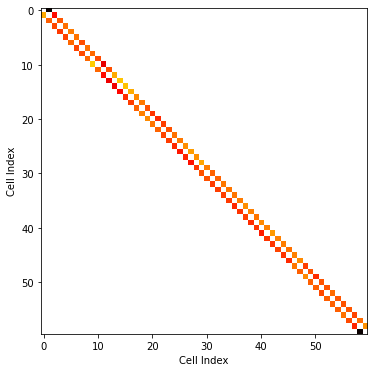

In [5]:
fig = plt.figure(figsize=[8,6])
ax = plt.imshow(KMAT, cmap='hot_r')
plt.xlabel('Cell Index'); plt.ylabel('Cell Index')

In [9]:
KMAT.shape

(60, 60)

In [14]:
#KMAT[55:60,55:60]

### $$\bf{K} = 
      \left(\begin{array}{cccccccccc}
        0.0 & 1.0 & 0.0 & \ldots\\
        0.4 & 0.0 & 0.6 & 0.0 & \ldots  \\
        0.0 & 0.5 &  0.0 & 0.5 & 0.0 & \ldots\\
        0.0 & 0.0 & \ddots &  \ddots & \ddots & 0.5 & 0.0  \\
        & \ldots &  0.0 & 0.0 &  0.6 & 0.0 & 0.4 \\
        & & \ldots & 0.0 & 0.0 &  1.0 & 0.0 \\
      \end{array}\right)$$

### $$\bf{K} = 
      \left(\begin{array}{cccccccccc}
        0.0 & 1.0 & 0.0 & \ldots\\
        0.4 & 0.0 & 0.6 & 0.0 & \ldots  \\
        0.0 & 0.5 &  0.0 & 0.5 & 0.0 & \ldots\\
        0.0 & 0.0 & \ddots &  \ddots & \ddots & 0.0  \\
        & \ldots &  0.0 & 0.6 & 0.0 & 0.4 \\
        & & \ldots & 0.0 & 1.0 &  0.0 \\
      \end{array}\right)$$

### Solve for stationary flux, q using eigenvalue sover and power iteration

In [8]:
# Provide appropriative boundary condition to the last milestone
bc_beg = ''
bc_end = 'reflective'
QK = KineticsQK(KMAT, ave_time, nM, bc = [bc_beg, bc_end])
PMF_power, q_power = QK.PowerIter(n_iters=30000)
PMF_eigen, q_eigen = QK.EigenSolver()

PMF_power = PMF_power - PMF_power.min()
PMF_eigen = PMF_eigen - PMF_eigen.min()

###  Compare q obtained from both methods

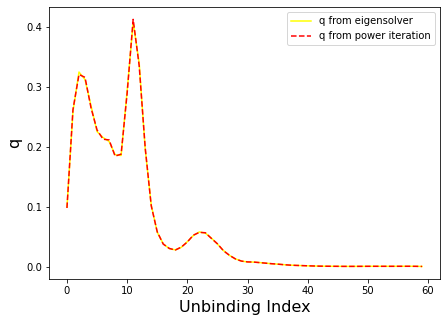

In [9]:
#cl='slategrey'
fig=plt.figure(figsize=[7,5])#facecolor=cl,)
#plt.rcParams['axes.facecolor'] = cl
plt.plot( range(len(q_eigen)), abs(q_eigen), color='yellow', label='q from eigensolver')
plt.plot( range(len(q_power)), q_power, '--',color='r', label='q from power iteration')
plt.legend()    
plt.xlabel('Unbinding Index', fontsize=16)
plt.ylabel('q', fontsize=16)
plt.show()

###  Visualize the potential of mean force (PMF) profile

In [10]:
b=0; f=nM-1

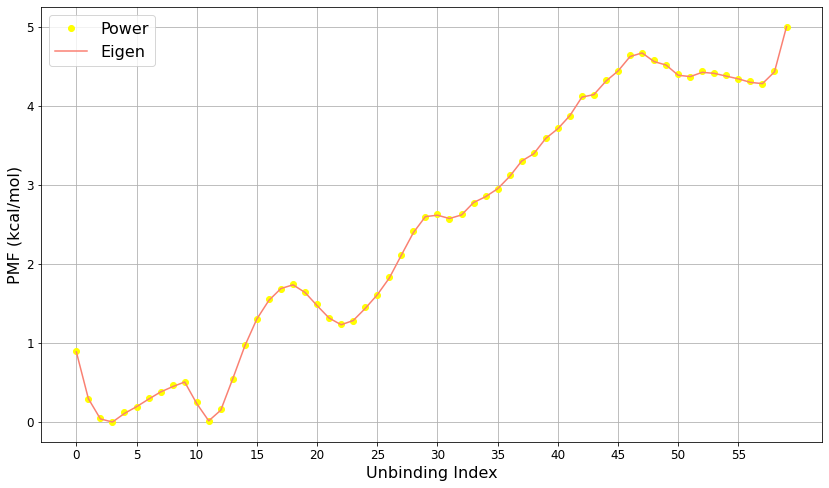

In [11]:
plt.figure(figsize=(14,8))
plt.plot(range(b,f+1), PMF_power, color='yellow', ls='', marker='o' )
plt.plot(range(b,f+1), PMF_eigen, color='salmon')
plt.xlabel('Unbinding Index',fontsize=16)
plt.ylabel('PMF (kcal/mol)', fontsize=16)
plt.xticks(np.arange(b,(f+1), step=5))
plt.tick_params(labelsize=12)
plt.grid()
plt.legend(['Power','Eigen'], fontsize=16)

ValueError: x and y must have same first dimension, but have shapes (57,) and (60,)

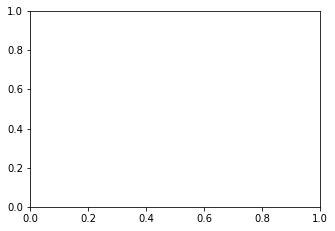

In [23]:
cl='darkcyan'; t_cl = 'brown'
pl_name = 'Cyc-Asp'
fs = 11; lw=.3
PMF = PMF_eigen
fig = plt.figure(figsize = [5.2, 3.6])
plt.plot(range(b,f+1), PMF, ls='--', lw=lw, color=cl)#, marker='o' )
plt.errorbar(range(b, f+1), PMF, F_std,
             color=cl, ecolor=cl,
             elinewidth=0.5, capsize=1)
plt.xlabel('Unbinding Index',fontsize=fs)
plt.ylabel('PMF (kcal/mol)', fontsize=fs)
plt.xticks(np.arange(b,(f+1), step=5))
plt.tick_params(labelsize=fs-2)
plt.xlim([0,60]); plt.ylim([0,6])
plt.grid(lw=lw)

fig.tight_layout()
plt.savefig(pl_name + 'FreeE.pdf')
plt.show()

### Calculate unbinding free energy, $\Delta G$

In [19]:
PMF_eigen = PMF_eigen[0:80] # rm last a few points
b_, f_ = np.argmin(PMF_eigen), np.argmax(PMF_eigen)
print("Free energy between milestones %s and %s:"%(b_, f_))
DeltaG = -(PMF_eigen[f_] - PMF_eigen[b_])
print("\u0394G =\t", DeltaG, "kcal/mol")

Free energy between milestones 3 and 59:
ΔG =	 -4.998289398953507 kcal/mol


In [20]:
PMF_power = PMF_power[0:80] # rm last a few points
b_, f_ = np.argmin(PMF_power), np.argmax(PMF_power)
print("Free energy between milestones %s and %s:"%(b_, f_))
DeltaG = -(PMF_power[f_] - PMF_power[b_])
print("\u0394G =\t", DeltaG, "kcal/mol")

Free energy between milestones 3 and 59:
ΔG =	 -4.998289398952811 kcal/mol


###  Calculate MFPT

In [21]:
time = np.array(time)
b = b_; f = f_
print("MFPT from milestone %s to %s:"%(b, f))
mfpt = abs( (q_power[b:f+1]*time[:,1][b:f+1]).sum() / q_power[-1]) / 10**9
print("MFPT =\t %E ms" % mfpt)


MFPT from milestone 3 to 59:
MFPT =	 8.782217E-05 ms


In [22]:
print("MFPT from milestone %s to %s:"%(b, f))
mfpt = abs( (q_eigen[b:f+1]*time[:,1][b:f+1]).sum() / q_eigen[-1]) / 10**9
print("MFPT =\t %E ms" % mfpt)

MFPT from milestone 3 to 59:
MFPT =	 8.884634E-05 ms
